# Load the Datasets

In [1]:
import os

folder_path = "E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset"
save_path = os.path.join(folder_path, "Saved_datasets")
train_num_shards = len(os.listdir(os.path.join(save_path, 'train')))
class_names = os.listdir(os.path.join(folder_path, "train"))

model_save_path = "E:/Gauava Disease Detection/Models/Saved_models"
os.makedirs(model_save_path, exist_ok=True)
model_path = os.path.join(model_save_path, "MobileNet.keras")

RANDOM_SEED_1 = 42  # Used for random shuffling and sampling
RANDOM_SEED_2 = 101 # Used for other purposes

In [2]:
train_num_shards

5

In [3]:
class_names

['Anthracnose', 'fruit_fly', 'healthy_guava']

In [4]:
import tensorflow as tf

In [5]:
save_path_subdir = os.path.join(save_path, 'train')
shards = []
for i in range(train_num_shards):
    shard_path = os.path.join(save_path_subdir, f'shard_{i}')
    shard_dataset = tf.data.Dataset.load(shard_path, compression='GZIP')
    shards.append(shard_dataset)

train_ds = shards[0]
for shard in shards[1:]:
    train_ds = train_ds.concatenate(shard)

In [6]:
save_path_subdir = os.path.join(save_path, 'test')
test_ds = tf.data.Dataset.load(save_path_subdir, compression='GZIP')

In [7]:
save_path_subdir = os.path.join(save_path, 'val')
val_ds = tf.data.Dataset.load(save_path_subdir, compression='GZIP')

In [8]:
train_ds = (
    train_ds
        .cache()
        .shuffle(buffer_size=train_ds.cardinality(), seed=RANDOM_SEED_1)
        .prefetch(tf.data.AUTOTUNE)
)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
for ds in [train_ds, test_ds, val_ds]:
    print(ds)
    print("Cardinality: ", ds.cardinality().numpy(), "\n")

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Cardinality:  83 

<_LoadDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Cardinality:  12 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Cardinality:  24 



# MobileNet Model

In [11]:
for image, label in train_ds.take(1):
    print(label.shape)
    print(image.shape)

(32, 3)
(32, 224, 224, 3)


## Hybrid Modelling

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [13]:
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

input = Input(shape=(224, 224, 3), dtype="float32")
x = preprocess_input(input)
x = mobilenet_base(x)
x = GlobalAveragePooling2D()(x)

# Create a feature extractor model
feature_extractor = Model(inputs=input, outputs=x)
feature_extractor.trainable = False  # Freeze MobileNet weights
feature_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [14]:
def extract_features(dataset: tf.data.Dataset, model: tf.keras.Model):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        features = model.predict(images.numpy())
        
        # Append features and labels
        all_features.append(features)
        all_labels.append(labels.numpy())
    
    # Concatenate all batches into a single array
    all_features = np.vstack(all_features)  # Shape: (n_samples, n_features)
    all_labels = np.vstack(all_labels)      # Shape: (n_samples, n_outputs)
    
    return all_features, all_labels

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

## Evaluation & Testing

In [16]:
# Flatten train, validation, and test datasets
train_features, train_labels = extract_features(train_ds, feature_extractor)
val_features, val_labels = extract_features(val_ds, feature_extractor)
test_features, test_labels = extract_features(test_ds, feature_extractor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Train Random Forest
rf_model.fit(train_features, train_labels)

val_predictions = rf_model.predict(val_features)
test_predictions = rf_model.predict(test_features)

Validation Accuracy: 0.9165562913907285
Test Accuracy: 0.900523560209424


In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(test_predictions, axis=1)

In [20]:
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}% \n")
print("Classification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 92.15% 

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       156
           1       1.00      0.88      0.94       132
           2       0.99      0.85      0.91        94

    accuracy                           0.92       382
   macro avg       0.94      0.91      0.92       382
weighted avg       0.93      0.92      0.92       382



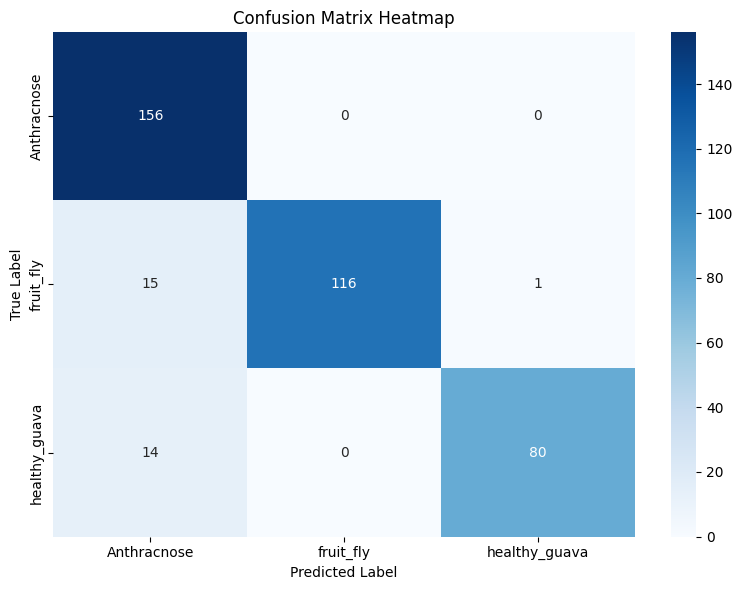

In [23]:
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and adjust layout
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

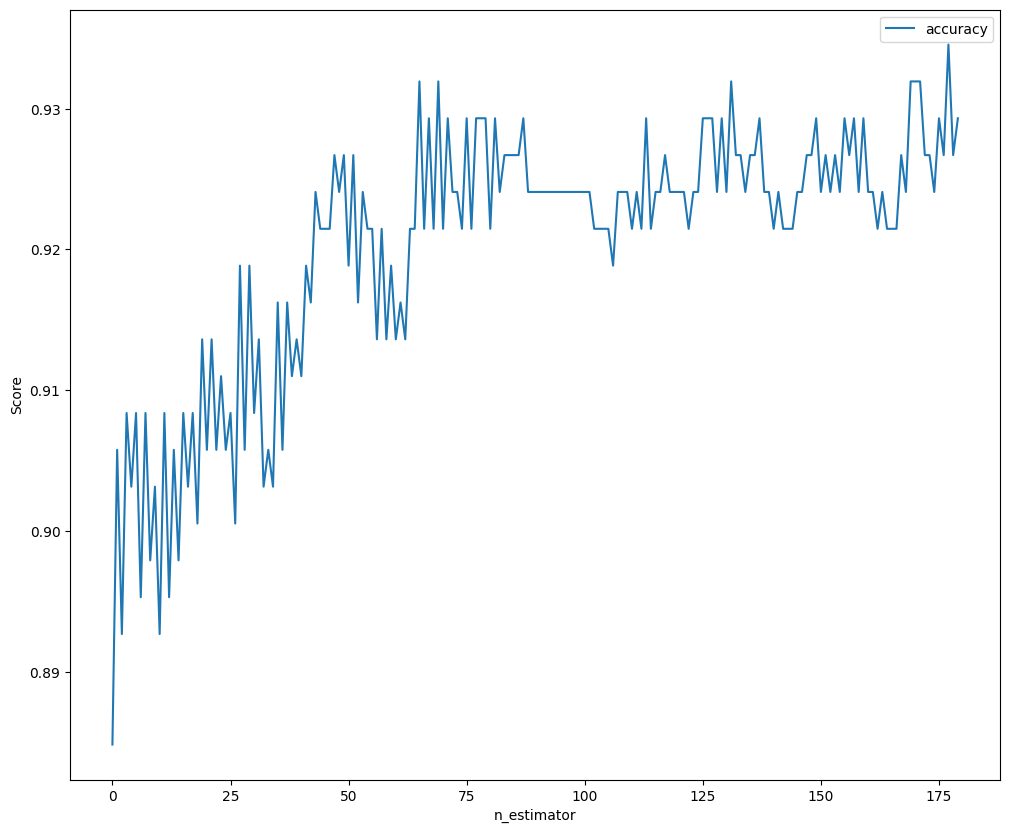

In [29]:
accuracy_matrix = []
for n_est in range(20, 200):
    print(n_est, end=' ')
    rf_model = RandomForestClassifier(n_estimators=n_est, random_state=42)
    
    # Train Random Forest
    rf_model.fit(train_features, train_labels)
    
    # Predict
    test_predictions = rf_model.predict(test_features)
    y_true = np.argmax(test_labels, axis=1)
    y_pred = np.argmax(test_predictions, axis=1)
    accuracy_matrix.append(accuracy_score(y_true, y_pred))
    

plt.figure(figsize=(12, 10))
sns.lineplot(accuracy_matrix, label='accuracy')
plt.ylabel('Score')
plt.xlabel('n_estimator')
plt.show()

In [30]:
accuracy_matrix[-3]

0.9345549738219895

Max. accuracy attained is around `99%`

In [22]:
model.save(model_path)

# Sample Prediction

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model = load_model(model_path)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575,051 (25.08 MB)

 Trainable params: 1,115,395 (4.25 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 2,230,792 (8.51 MB)

In [26]:
import random
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test\Anthracnose\134_unsharp_clahe_augmented_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
Predicted class index: [0]
Predicted class label: Anthracnose


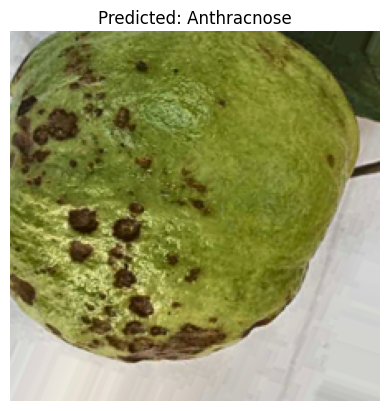

E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test\fruit_fly\70_unsharp_clahe_augmented_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted class index: [1]
Predicted class label: fruit_fly


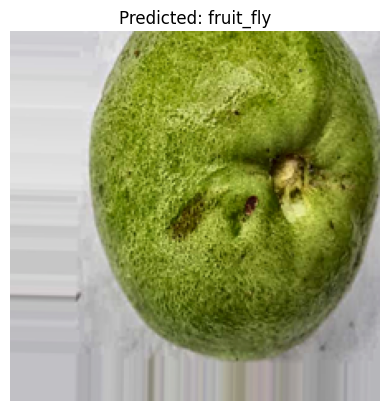

E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test\healthy_guava\89_unsharp_clahe_augmented_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted class index: [2]
Predicted class label: healthy_guava


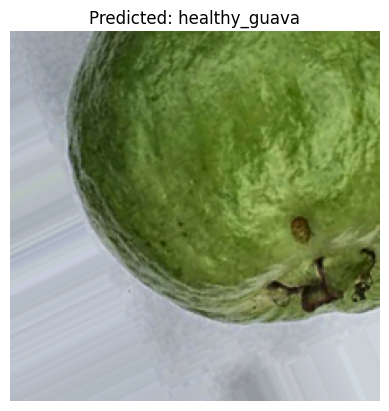

In [27]:
test_dir = "E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test"
test_subdirs = [os.path.join(test_dir, _) for _ in os.listdir(test_dir)]

for subdir in test_subdirs:
    images = os.listdir(subdir)
    n = len(images)
    pick_n = random.randint(0, n)
    picked_img_dir = os.path.join(subdir, images[pick_n])
    print(picked_img_dir)

    # Load and display the sample image
    img = Image.open(picked_img_dir)
    img.show()
    img_resized = img.resize((224, 224))  # Adjust to your model's input size
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)  # Get the class index
    print(f"Predicted class index: {predicted_class}")
    print(f"Predicted class label: {class_names[predicted_class[0]]}")

    # Display the image with the predicted label
    plt.imshow(img_resized)
    plt.title(f"Predicted: {class_names[predicted_class[0]]}")
    plt.axis('off')
    plt.show()